In [1]:
import random
from collections import defaultdict, deque
import matplotlib.pyplot as plt

In [2]:
random.seed(42)

In [3]:
def gen_order_id():
    i = 0
    while True:
        yield f"O{i}"
        i += 1

In [4]:
_order_id_gen = gen_order_id()

In [5]:
class Order:
    def __init__(self, trader_id, side, price, size, order_type='limit', timestamp=0):
        self.id = next(_order_id_gen)
        self.trader_id = trader_id
        self.side = side  # 'bid' or 'ask'
        self.price = price  # integer ticks or None for market
        self.size = size
        self.remaining = size
        self.type = order_type  # 'limit' or 'market'
        self.timestamp = timestamp

In [6]:
class LimitOrderBook:
    def __init__(self, mid_price=10000, tick_size=1, max_levels=100):
        self.mid_price = mid_price
        self.tick = tick_size
        self.bids = defaultdict(deque)
        self.asks = defaultdict(deque)
        self.bids_prices = set()
        self.asks_prices = set()
        self.order_map = {}  # order_id -> (order, container)
        self.trade_history = []  # (time, price, size, taker_id, maker_id)
        self.time = 0
        self.max_levels = max_levels
        # Per-trader accounting (inventory, cash)
        self.trader_inventory = defaultdict(int)
        self.trader_cash = defaultdict(float)

    def best_bid(self):
        return max(self.bids_prices) if self.bids_prices else None

    def best_ask(self):
        return min(self.asks_prices) if self.asks_prices else None

    def mid(self):
        bb = self.best_bid()
        ba = self.best_ask()
        if bb is None and ba is None:
            return self.mid_price
        if bb is None:
            return ba - self.tick
        if ba is None:
            return bb + self.tick
        return (bb + ba) / 2.0

    def place_limit_order(self, order: Order):
        # match if crossing
        if order.side == 'bid':
            if self.best_ask() is not None and order.price >= self.best_ask():
                self._match_order(order)
                if order.remaining > 0:
                    self._add_to_book(order)
            else:
                self._add_to_book(order)
        else:
            if self.best_bid() is not None and order.price <= self.best_bid():
                self._match_order(order)
                if order.remaining > 0:
                    self._add_to_book(order)
            else:
                self._add_to_book(order)

    def place_market_order(self, side, size, trader_id):
        order = Order(trader_id=trader_id, side=side, price=None, size=size, order_type='market', timestamp=self.time)
        self._match_order(order)
        return order

    def _add_to_book(self, order):
        container = self.bids if order.side == 'bid' else self.asks
        prices_set = self.bids_prices if order.side == 'bid' else self.asks_prices
        container[order.price].append(order)
        prices_set.add(order.price)
        self.order_map[order.id] = (order, container)
        # trim far levels
        if len(prices_set) > self.max_levels:
            if order.side == 'bid':
                far = min(prices_set)
                while container[far]:
                    o = container[far].popleft()
                    self.order_map.pop(o.id, None)
                del container[far]
                prices_set.remove(far)
            else:
                far = max(prices_set)
                while container[far]:
                    o = container[far].popleft()
                    self.order_map.pop(o.id, None)
                del container[far]
                prices_set.remove(far)

    def _match_order(self, taker_order: Order):
        if taker_order.side == 'bid':
            opposite = self.asks
            opp_prices = sorted(self.asks_prices)
            price_cmp = lambda p: p <= taker_order.price if taker_order.price is not None else True
        else:
            opposite = self.bids
            opp_prices = sorted(self.bids_prices, reverse=True)
            price_cmp = lambda p: p >= taker_order.price if taker_order.price is not None else True

        for p in opp_prices:
            if taker_order.price is not None and not price_cmp(p):
                break
            queue = opposite[p]
            while queue and taker_order.remaining > 0:
                maker = queue[0]
                trade_size = min(maker.remaining, taker_order.remaining)
                trade_price = maker.price if maker.price is not None else p
                # record
                self.trade_history.append((self.time, trade_price, trade_size,
                                           taker_order.trader_id if taker_order.side=='bid' else maker.trader_id,
                                           maker.trader_id if taker_order.side=='bid' else taker_order.trader_id))
                # update accounting: buyer inventory +, buyer cash -, seller inventory -, seller cash +
                if taker_order.side == 'bid':
                    buyer = taker_order.trader_id
                    seller = maker.trader_id
                else:
                    buyer = maker.trader_id
                    seller = taker_order.trader_id
                # apply cash/inventory transfer at trade_price
                self.trader_inventory[buyer] += trade_size
                self.trader_inventory[seller] -= trade_size
                self.trader_cash[buyer] -= trade_price * trade_size
                self.trader_cash[seller] += trade_price * trade_size

                maker.remaining -= trade_size
                taker_order.remaining -= trade_size
                if maker.remaining == 0:
                    queue.popleft()
                    self.order_map.pop(maker.id, None)
                if not queue:
                    if taker_order.side == 'bid':
                        self.asks_prices.discard(p)
                        del self.asks[p]
                    else:
                        self.bids_prices.discard(p)
                        del self.bids[p]
                if taker_order.remaining == 0:
                    break

    def cancel_order(self, order_id):
        if order_id not in self.order_map:
            return False
        order, container = self.order_map.pop(order_id)
        q = container[order.price]
        newq = deque([o for o in q if o.id != order_id])
        container[order.price] = newq
        if not newq:
            if container is self.bids:
                self.bids_prices.discard(order.price)
                del self.bids[order.price]
            else:
                self.asks_prices.discard(order.price)
                del self.asks[order.price]
        return True

    def step_time(self):
        self.time += 1


In [7]:
class NoiseTrader:
    def __init__(self, trader_id, market: LimitOrderBook, rate=0.2):
        self.id = trader_id
        self.mkt = market
        self.rate = rate

    def act(self):
        if random.random() < self.rate:
            side = random.choice(['bid', 'ask'])
            size = random.randint(1, 3)
            self.mkt.place_market_order(side=side, size=size, trader_id=self.id)


In [8]:
class InformedTrader:
    def __init__(self, trader_id, market: LimitOrderBook, info_prob=0.05, strength=4):
        self.id = trader_id
        self.mkt = market
        self.info_prob = info_prob
        self.strength = strength

    def act(self, signal=None):
        if signal is None:
            if random.random() < self.info_prob:
                signal = random.choice([1, -1])
            else:
                return
        if signal == 1:
            self.mkt.place_market_order(side='bid', size=self.strength, trader_id=self.id)
        elif signal == -1:
            self.mkt.place_market_order(side='ask', size=self.strength, trader_id=self.id)


In [9]:
import warnings
warnings.filterwarnings('ignore')
import gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from gym import spaces


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [10]:
def simulate_hawkes(mu, alpha, beta, T):
    arrivals = []
    t = 0
    λ = mu
    while t < T:
        # Step 1: sample candidate time increment
        u = np.random.uniform()
        w = -np.log(u) / λ
        t = t + w
        if t > T: break

        # Step 2: update intensity
        λ_t = mu + alpha * np.sum(np.exp(-beta * (t - np.array(arrivals))))
        d = np.random.uniform()
        if d <= λ_t / λ:
            arrivals.append(t)
        λ = λ_t
    return arrivals


In [18]:
class MarketMakerEnv(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(self, arrival_process="poisson"):
        super(MarketMakerEnv, self).__init__()

        # Action space: 16 discrete actions (bid_offset 0–3 × ask_offset 0–3)
        self.action_space = spaces.Discrete(16)

        # Observation space: [mid_price, spread, depth_bid, depth_ask, inventory, wealth]
        # Normalize by reasonable ranges
        obs_low  = np.array([0, 0, 0, 0, -100, -1e6], dtype=np.float32)
        obs_high = np.array([1e6, 1e3, 1e4, 1e4, 100, 1e6], dtype=np.float32)
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32)
        # Parameters for penalties
        self.inventory_limit = 50
        self.inventory_penalty_coeff = 0.1
        self.transaction_fee_rate = 0.001  
        self.arrival_process = arrival_process
        self.arrival_rate = 5.0           # Poisson λ per step
        self.hawkes_mu = 0.5             # baseline intensity
        self.hawkes_alpha = 0.8          # excitation per event
        self.hawkes_beta = 1.5           # decay rate
        self.hawkes_history = []         # store past arrivals (time stamps)

        # LOB instance
        self.lob = LimitOrderBook()
        # Internal state
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.mid_price = 100.0
        self.spread = 1.0
        self.depth_bid = 30
        self.depth_ask = 30
        self.agent_inventory = 0
        self.agent_wealth = 0.0

        obs = np.array([self.mid_price, self.spread, self.depth_bid,
                        self.depth_ask, self.agent_inventory, self.agent_wealth],
                    dtype=np.float32)
        info = {}  # you can add extra debug info here later
        return obs, info

    def step(self, action):
        bid_offset = action // 4
        ask_offset = action % 4

        n_orders = np.random.poisson(lam=self.arrival_rate)
        for _ in range(n_orders):
            side = np.random.choice(['bid', 'ask'])
            order_type = np.random.choice(['limit', 'market'], p=[0.7, 0.3])
            size = np.random.randint(1, 5)
            if order_type == 'limit':
                price = int(self.mid_price) + np.random.randint(-3, 4)  # within 3 ticks
                self.lob.place_limit_order(Order(trader_id="bg", side=side, 
                                                price=price, size=size, 
                                                order_type='limit', 
                                                timestamp=self.lob.time))
            else:
                self.lob.place_market_order(side, size, trader_id="bg")

        # advance time in LOB
        self.lob.step_time()

        # update environment state from LOB
        self.mid_price = self.lob.mid()
        self.spread = self.lob.best_ask() - self.lob.best_bid() if self.lob.best_bid() and self.lob.best_ask() else 1.0
        trade_direction = np.random.choice([-1, 0, 1])   # -1 sell, +1 buy, 0 no trade
        trade_size = np.random.choice([0,1,2])

        self.agent_inventory += trade_direction * trade_size
        self.agent_wealth += trade_size * (0.5 * (ask_offset - bid_offset))

        self.mid_price += np.random.normal(0, 0.1)
        self.spread = ask_offset + bid_offset + 1

        obs = np.array([self.mid_price, self.spread, self.depth_bid,
                        self.depth_ask, self.agent_inventory, self.agent_wealth],
                    dtype=np.float32)
        prev_wealth = self.agent_wealth
        # current reward
        
        reward = self.agent_wealth - prev_wealth  

        # add penalty
        reward -= self.inventory_penalty_coeff * (self.agent_inventory ** 2)

        
        terminated = False  # no terminal condition yet
        truncated = False   # no time-limit truncation yet
        info = {}
        # if abs(self.agent_inventory) > self.inventory_limit:
        #     done = True
        #     reward -= 1000000
        return obs, reward, terminated, truncated, info

    def render(self, mode="human"):
        print(f"Price {self.mid_price:.2f}, Wealth {self.agent_wealth:.2f}, Inv {self.agent_inventory}")

In [19]:
env = DummyVecEnv([lambda: MarketMakerEnv()])

model = PPO(
    "MlpPolicy", env, verbose=1,
    learning_rate=3e-5,
    gamma=0.99,
    n_steps=512,
    batch_size=64,
    ent_coef=0.01,
    tensorboard_log="./mm_tensorboard/",
)

# Train agent
timesteps = 50_000
model.learn(total_timesteps=timesteps)

# Save trained model
model.save("ppo_market_maker")
print("Training done and model saved!")

Using cpu device
Logging to ./mm_tensorboard/PPO_21
-----------------------------
| time/              |      |
|    fps             | 1283 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 512  |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1005        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.000256115 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.77       |
|    explained_variance   | -3.81e-05   |
|    learning_rate        | 3e-05       |
|    loss                 | 1.89e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0018     |
|    value_loss           | 4.87e+03    |
------------------------

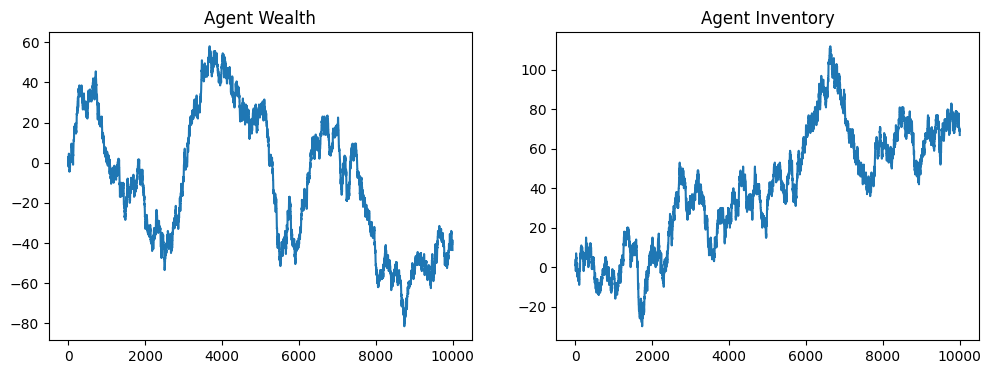

In [20]:
# Wrap in DummyVecEnv
eval_env = DummyVecEnv([lambda: MarketMakerEnv()])

# Load model
model = PPO.load("ppo_market_maker")

obs = eval_env.reset()
wealth_history, inventory_history = [], []

for step in range(10000):
    action, _ = model.predict(obs, deterministic=False)
    obs, reward, done, info = eval_env.step(action)
    wealth_history.append(eval_env.envs[0].agent_wealth)
    inventory_history.append(eval_env.envs[0].agent_inventory)
    if done:
        obs = eval_env.reset()

# Plot results
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(wealth_history)
plt.title("Agent Wealth")
plt.subplot(1,2,2)
plt.plot(inventory_history)
plt.title("Agent Inventory")
plt.show()
